# Package import, API keys

In [1]:
import pandas as pd
import numpy as np
from random import shuffle
from osgeo import ogr, osr
from sentinelhub import WmsRequest, WcsRequest, MimeType, CRS, BBox, constants
import logging
from collections import Counter
import datetime
import os
import yaml
from sentinelhub import DataSource
import scipy.sparse as sparse
from scipy.sparse.linalg import splu
from skimage.transform import resize
from sentinelhub import CustomUrlParam
from time import time as timer
import multiprocessing
import math
import reverse_geocoder as rg
import pycountry
import pycountry_convert as pc
import hickle as hkl
from shapely.geometry import Point, Polygon
import geopandas
from tqdm import tnrange, tqdm_notebook
import math
import boto3
from pyproj import Proj, transform
from timeit import default_timer as timer
from typing import Tuple, List
import warnings
from scipy.ndimage import median_filter
import datetime
from time import time
import copy


In [2]:
%run ../src/preprocessing/slope.py
%run ../src/preprocessing/indices.py
%run ../src/downloading/utils.py
%run ../src/preprocessing/cloud_removal.py
%run ../src/preprocessing/whittaker_smoother.py
%run ../src/downloading/upload.py
%run ../src/tof/tof_downloading.py

ERROR:root:File `'../src/downloading/upload.py'` not found.


In [3]:
if os.path.exists("../config.yaml"):
    with open("../config.yaml", 'r') as stream:
        key = (yaml.safe_load(stream))
        API_KEY = key['key']
        AWSKEY = key['awskey']
        AWSSECRET = key['awssecret']
else:
    API_KEY = "none"

# (Optional) Make the tiling ID structure

The data is processed in 6 x 6 km tiles. The following code will calculate the x, y tile IDs for a given CSV file containing tile centroids as lat, lon pairs

In [5]:
data = pd.read_csv("../src/processing_area_june_23.csv")

make_tile = True

if make_tile:
    def id_tile_number(idx, col):
        vals = data[col]
        vals_set = sorted(np.unique(vals))
        no = np.argwhere(vals_set == idx).flatten()
        return str(no[0])

    y_tiles = np.empty((len(data)))
    data = data.reset_index()
    for idx in tnrange(len(data)):
        y_tiles[idx] = (id_tile_number(data['Y'][idx], 'Y'))

    y_tiles = list(y_tiles)
    y_tiles = [str(x) for x in y_tiles]
    data['Y_tile'] = y_tiles
    data.to_csv("../src/processing_area_june_23.csv")

    x_tiles = np.empty((len(data)))
    data = data.reset_index()
    for idx in tnrange(len(data)):
        x_tiles[idx] = (id_tile_number(data['X'][idx], 'X'))

    x_tiles = list(x_tiles)
    x_tiles = [str(x) for x in x_tiles]
    data['X_tile'] = x_tiles
    data.to_csv("../src/processing_area_june_23.csv")
    
"""   
tracker = pd.DataFrame({'X_tile': [], 'Y_tile': []})
x_tiles = [x for x in os.listdir("../project-monitoring/tof/") if '.DS' not in x]
x_tiles = [x for x in x_tiles if '.csv' not in x]
for x_tile in x_tiles:
    y_tiles = os.listdir("../project-monitoring/tof/" + x_tile)
    y_tiles = [y for y in y_tiles if '.DS' not in y]
    y_tiles = [y for y in y_tiles if '.tif' not in y]
    for y_tile in y_tiles:
        tracker = tracker.append({'X_tile': int(x_tile), 'Y_tile': int(y_tile)}, ignore_index = True)

tracker = pd.merge(tracker, data)
tracker.to_csv("../project-monitoring/tof/tracker.csv")
"""

KeyboardInterrupt: 

In [ ]:
data = data.drop(['VALUE'], axis = 1)

In [18]:
data.to_csv("../src/processing_area_may_18.csv")

# Super resolution

In [5]:
import tensorflow as tf
sess = tf.Session()
from keras import backend as K
K.set_session(sess)

MDL_PATH = "../models/supres/"

model = tf.train.import_meta_graph(MDL_PATH + 'model.meta')
model.restore(sess, tf.train.latest_checkpoint(MDL_PATH))

logits = tf.get_default_graph().get_tensor_by_name("Add_6:0")
inp = tf.get_default_graph().get_tensor_by_name("Placeholder:0")
inp_bilinear = tf.get_default_graph().get_tensor_by_name("Placeholder_1:0")


def superresolve_tile(arr: np.ndarray, sess = sess) -> np.ndarray:
    """Superresolves each 56x56 subtile in a 646x646 input tile
       by padding the subtiles to 64x64 and removing the pad after prediction,
       eliminating boundary artifacts

        Parameters:
         arr (arr): (?, 646, 646, 10) array

        Returns:
         superresolved (arr): (?, 646, 646, 10) array
    """

    to_resolve = np.pad(arr, ((0, 0), (4, 4), (4, 4), (0, 0)), 'reflect')

    bilinear = to_resolve[..., 4:]
    resolved = sess.run([logits], 
                 feed_dict={inp: to_resolve,
                            inp_bilinear: bilinear})[0]
    resolved = resolved[:, 4:-4, 4:-4, :]
    arr[..., 4:] = resolved
    return arr

Using TensorFlow backend.


# Tiling functions

In [6]:
def make_output_and_temp_folders(output_folder: str) -> None:
    """Makes necessary folder structures for IO of raw and processed data

        Parameters:
         idx (str)
         output_folder (path)

        Returns:
         None
    """
    def _find_and_make_dirs(dirs):
        if not os.path.exists(os.path.realpath(dirs)):
            os.makedirs(os.path.realpath(dirs))
            
    folders = ['raw/', 'raw/clouds/', 'raw/misc/', 'raw/s1/',
              'raw/s2_10/', 'raw/s2_20/']
    
    for folder in folders:
        _find_and_make_dirs(output_folder + folder)
        
def make_bbox(initial_bbx: list, expansion: int = 10) -> list:
    """
    Makes a (min_x, min_y, max_x, max_y) bounding box that
    is 2 * expansion 300 x 300 meter ESA LULC pixels
    """
    

    multiplier = 1/360
    bbx = copy.deepcopy(initial_bbx)
    bbx[0] -= expansion * multiplier
    bbx[1] -= expansion * multiplier
    bbx[2] += expansion * multiplier
    bbx[3] += expansion * multiplier
    return bbx
    

def download_tile(x: int, y: int, data: pd.DataFrame) -> None:
    data = data[data['Y_tile'] == int(y)]
    data = data[data['X_tile'] == int(x)]
    data = data.reset_index(drop = True)
    x = str(int(x))
    y = str(int(y))
    if ".0" in x:
        x = x[:-2]
    if ".0" in y:
        y = y[:-2]
        
    initial_bbx = [data['X'][0], data['Y'][0], data['X'][0], data['Y'][0]]

    bbx = make_bbox(initial_bbx, expansion = 300/30)
    dem_bbx = make_bbox(initial_bbx, expansion = 301/30)
        
    folder = f"../project-monitoring/tof/{str(x)}/{str(y)}/"
    tile_idx = f'{str(x)}X{str(y)}Y'
    
    make_output_and_temp_folders(folder)        
    clouds_file = f'{folder}raw/clouds/clouds_{tile_idx}.hkl'
    shadows_file = f'{folder}raw/clouds/shadows_{tile_idx}.hkl'
    s1_file = f'{folder}raw/s1/{tile_idx}.hkl'
    s1_dates_file = f'{folder}raw/misc/s1_dates_{tile_idx}.hkl'
    s2_10_file = f'{folder}raw/s2_10/{tile_idx}.hkl'
    s2_20_file = f'{folder}raw/s2_20/{tile_idx}.hkl'
    s2_dates_file = f'{folder}raw/misc/s2_dates_{tile_idx}.hkl'
    s2_file = f'{folder}raw/s2/{tile_idx}.hkl'
    clean_steps_file = f'{folder}raw/clouds/clean_steps_{tile_idx}.hkl'
    dem_file = f'{folder}raw/misc/dem_{tile_idx}.hkl'
    
    print(f"Downloading {x, y} tile to {folder}, with a"
          f" bounding box of {bbx}")
    
    
    if not (os.path.exists(clouds_file)):# or processed):
        print(f"Downloading {clouds_file}")

        cloud_probs, shadows, _, image_dates, _ = identify_clouds(bbox = bbx,
                                                               dates = dates,
                                                              imsize = 600,
                                                              api_key = API_KEY,
                                                              year = 2020)

        to_remove, _ = calculate_cloud_steps(cloud_probs, image_dates)

        if len(to_remove) > 0:
            clean_dates = np.delete(image_dates, to_remove)
            cloud_probs = np.delete(cloud_probs, to_remove, 0)
            shadows = np.delete(shadows, to_remove, 0)
        else:
            clean_dates = image_dates
            
        to_remove = subset_contiguous_sunny_dates(clean_dates)
        if len(to_remove) > 0:
            clean_dates = np.delete(clean_dates, to_remove)
            cloud_probs = np.delete(cloud_probs, to_remove, 0)
            shadows = np.delete(shadows, to_remove, 0)

        hkl.dump(cloud_probs, clouds_file, mode='w', compression='gzip')
        hkl.dump(shadows, shadows_file, mode='w', compression='gzip')
        hkl.dump(clean_dates, clean_steps_file, mode='w', compression='gzip')
            
    
    if not (os.path.exists(s2_10_file)):
        print(f"Downloading {s2_10_file}")
        clean_steps = list(hkl.load(clean_steps_file))
        cloud_probs = hkl.load(clouds_file)
        shadows = hkl.load(shadows_file)    
        s2_10, s2_20, s2_dates = download_sentinel_2(bbx, clean_steps = clean_steps,
                                                     api_key = API_KEY,
                                                     dates = dates,
                                                     year = 2020
                                                    )

        # Steps to ensure that L2A, L1C derived products have exact matching dates
        print(f"Shadows {shadows.shape}, clouds {cloud_probs.shape},"
              f" S2, {s2_10.shape}, S2d, {s2_dates.shape}")
        to_remove_clouds = [i for i, val in enumerate(clean_steps) if val not in s2_dates]
        to_remove_dates = [val for i, val in enumerate(clean_steps) if val not in s2_dates]
        if len(to_remove_clouds) >= 1:
            print(f"Removing {to_remove_dates} from clouds because not in S2")
            cloud_probs = np.delete(cloud_probs, to_remove_clouds, 0)
            shadows = np.delete(shadows, to_remove_clouds, 0)
            hkl.dump(cloud_probs, clouds_file, mode='w', compression='gzip')
            hkl.dump(shadows, shadows_file, mode='w', compression='gzip')

        assert cloud_probs.shape[0] == s2_10.shape[0], "There is a date mismatch"
        hkl.dump(to_int16(s2_10), s2_10_file, mode='w', compression='gzip')
        hkl.dump(to_int16(s2_20), s2_20_file, mode='w', compression='gzip')
        hkl.dump(s2_dates, s2_dates_file, mode='w', compression='gzip')
        
        s210_arr = to_int16(s2_10[0, ..., 0])
        s220_arr = to_int16(s2_20[0, ..., 0])
            
    if not (os.path.exists(s1_file)):
        print(f"Downloading {s1_file}")
        s1_layer = identify_s1_layer((data['X'][0], data['Y'][0]))
        s1, s1_dates = download_sentinel_1(bbx,
                                           layer = s1_layer,
                                           api_key = API_KEY,
                                           year = 2020,
                                           dates = dates_sentinel_1)
        if s1.shape[0] == 0:
            s1_layer = "SENT_DESC" if s1_layer == "SENT" else "SENT"
            print(f'Switching to {s1_layer}')
            s1, s1_dates = download_sentinel_1(bbx,
                                               layer = s1_layer,
                                               api_key = API_KEY,
                                               year = 2020,
                                               dates = dates_sentinel_1)
        s1 = process_sentinel_1_tile(s1, s1_dates)
        hkl.dump(to_int16(s1), s1_file, mode='w', compression='gzip')
        hkl.dump(s1_dates, s1_dates_file, mode='w', compression='gzip')
        
        s1_arr = to_int16(s1[0, ..., 0])
        
    if not os.path.exists(dem_file):
        print(f'Downloading {dem_file}')
        dem = download_dem(dem_bbx, api_key = API_KEY)
        hkl.dump(dem, dem_file, mode='w', compression='gzip')
    

In [7]:
def id_missing_px(sentinel2: np.ndarray, thresh: int = 11) -> np.ndarray:
    """Identifies missing (na) values in input array
    """
    missing_images_0 = np.sum(sentinel2[..., :10] == 0.0, axis = (1, 2, 3))
    missing_images_p = np.sum(sentinel2[..., :10] >= 1., axis = (1, 2, 3))
    missing_images = missing_images_0 + missing_images_p
    
    missing_images = np.argwhere(missing_images >= (sentinel2.shape[1]**2) / thresh)
    missing_images = missing_images.flatten()
    if len(missing_images) > 0:
        print(f"The missing image bands (0) are: {missing_images_0}")
        print(f"The missing image bands (1.0) are: {missing_images_p}")
    return missing_images

def process_tile(x: int, y: int, data: pd.DataFrame):
    
    x = str(int(x))
    y = str(int(y))
    if ".0" in x:
        x = x[:-2]
    if ".0" in y:
        y = y[:-2]
            
    folder = f"../project-monitoring/tof/{str(x)}/{str(y)}/"
    tile_idx = f'{str(x)}X{str(y)}Y'
    
    clouds_file = f'{folder}raw/clouds/clouds_{tile_idx}.hkl'
    shadows_file = f'{folder}raw/clouds/shadows_{tile_idx}.hkl'
    s1_file = f'{folder}raw/s1/{tile_idx}.hkl'
    s1_dates_file = f'{folder}raw/misc/s1_dates_{tile_idx}.hkl'
    s2_10_file = f'{folder}raw/s2_10/{tile_idx}.hkl'
    s2_20_file = f'{folder}raw/s2_20/{tile_idx}.hkl'
    s2_dates_file = f'{folder}raw/misc/s2_dates_{tile_idx}.hkl'
    s2_file = f'{folder}raw/s2/{tile_idx}.hkl'
    clean_steps_file = f'{folder}raw/clouds/clean_steps_{tile_idx}.hkl'
    dem_file = f'{folder}raw/misc/dem_{tile_idx}.hkl'
    
    
    clouds = hkl.load(clouds_file)
    shadows = hkl.load(shadows_file)
    s1 = hkl.load(s1_file)
    s2_10 = to_float32(hkl.load(s2_10_file))
    s2_20 = to_float32(hkl.load(s2_20_file))
    dem = hkl.load(dem_file)
    image_dates = hkl.load(s2_dates_file)
    
    s1 = np.reshape(s1, (12, s1.shape[1] // 2, 2, s1.shape[2] // 2, 2, 2))
    s1 = np.mean(s1, axis = (2, 4))
    
    
    width = s2_10.shape[1]
    height = s2_20.shape[2] * 2
    
    if clouds.shape[1] < width:
        pad_amt =  (width - clouds.shape[1]) // 2
        clouds = np.pad(clouds, ((0, 0), (pad_amt, pad_amt), (0,0)), 'edge')
        
    if shadows.shape[1] < width:
        pad_amt =  (width - shadows.shape[1]) // 2
        shadows = np.pad(shadows, ((0, 0), (pad_amt, pad_amt), (0,0)), 'edge')
        
    if dem.shape[0] < width:
        pad_amt =  (width - dem.shape[0]) // 2
        dem = np.pad(dem, ((pad_amt, pad_amt), (0, 0)), 'edge')
        
    if s2_10.shape[2] < height:
        pad_amt =  (height - s2_10.shape[2]) / 2
        if pad_amt % 2 == 0:
            pad_amt = int(pad_amt)
            s2_10 = np.pad(s2_10, ((0, 0), (0, 0), (pad_amt, pad_amt), (0,0)), 'edge')
        else:
            s2_10 = np.pad(s2_10, ((0, 0), (0, 0), (0, int(pad_amt * 2)), (0,0)), 'edge')
    
    if s2_10.shape[2] > height:
        pad_amt =  abs(height - s2_10.shape[2])
        s2_10 = s2_10[:, :, :-pad_amt, :]
        print(s2_10.shape)
       
    if dem.shape[1] < height:
        pad_amt =  (height - dem.shape[1]) / 2
        if pad_amt % 2 == 0:
            pad_amt = int(pad_amt)
            dem = np.pad(dem, ((0, 0), (pad_amt, pad_amt)), 'edge')
        else:
            dem = np.pad(dem, ( (0, 0), (0, int(pad_amt * 2))), 'edge')
            
    if dem.shape[1] > height:
        pad_amt =  abs(height - dem.shape[1])
        dem = dem[:, :-pad_amt]
        
        
    print(f'Clouds: {clouds.shape}, \nShadows: {shadows.shape} \n'
          f'S1: {s1.shape} \nS2: {s2_10.shape}, {s2_20.shape} \nDEM: {dem.shape}')
            
  
    sentinel2 = np.empty((s2_10.shape[0], width, height, 10))
    sentinel2[..., :4] = s2_10
    for band in range(6):
        for time in range(sentinel2.shape[0]):
            sentinel2[time, ..., band + 4] = resize(s2_20[time,..., band], (width, height), 1)

    missing_px = id_missing_px(sentinel2, 3)
    if len(missing_px) > 0:
        print(f"Removing {missing_px} dates due to missing data")
        clouds = np.delete(clouds, missing_px, axis = 0)
        shadows = np.delete(shadows, missing_px, axis = 0)
        image_dates = np.delete(image_dates, missing_px)
        sentinel2 = np.delete(sentinel2, missing_px, axis = 0)

    x, interp = remove_cloud_and_shadows(sentinel2, clouds, shadows, image_dates) 

    dem_i = np.tile(dem[np.newaxis, :, :, np.newaxis], (x.shape[0], 1, 1, 1))
    dem_i = dem_i / 90
    x = np.concatenate([x, dem_i], axis = -1)
    x = np.clip(x, 0, 1)
    return x, image_dates, interp, s1

In [8]:
def make_subtiles(folder, tiles):
    
    y_tiles = np.unique(tiles[:, 1])
    x_tiles = np.unique(tiles[:, 0])
    
    def _find_and_make_dirs(dirs):
        if not os.path.exists(os.path.realpath(dirs)):
            os.makedirs(os.path.realpath(dirs))
    
    for y_tile in y_tiles:
        _find_and_make_dirs(folder + str(y_tile) + '/')
            
def interpolate_na_vals(s2):
    '''Interpolates NA values with closest time steps, to deal with
       the small potential for NA values in calculating indices'''
    for x_loc in range(s2.shape[1]):
        for y_loc in range(s2.shape[2]):
            n_na = np.sum(np.isnan(s2[:, x_loc, y_loc, :]), axis = 1)
            for date in range(s2.shape[0]):
                if n_na.flatten()[date] > 0:
                    before, after = calculate_proximal_steps(date, np.argwhere(n_na == 0))
                    s2[date, x_loc, y_loc, :] = ((s2[date + before, x_loc, y_loc] + 
                                                 s2[date + after, x_loc, y_loc]) / 2)
    numb_na = np.sum(np.isnan(s2), axis = (1, 2, 3))
    if np.sum(numb_na) > 0:
        print(f"There are {numb_na} NA values")
    return s2
    

def process_subtiles(x, y, s2: np.ndarray = None, 
                       dates: np.ndarray = None,
                       interp: np.ndarray = None, s1 = None) -> None:
    '''Wrapper function to interpolate clouds and temporal gaps, superresolve tiles,
       calculate relevant indices, and save analysis-ready data to the output folder
       
       Parameters:
        coord (tuple)
        step_x (int):
        step_y (int):
        folder (str):

       Returns:
        None
    '''
    x = str(int(x))
    y = str(int(y))
    if ".0" in x:
        x = x[:-2]
    if ".0" in y:
        y = y[:-2]
    
    s2 = interpolate_na_vals(s2)
    
    tiles_folder = tile_window(s2.shape[2], s2.shape[1], window_size = 140)
    tiles_array = make_overlapping_windows(tiles_folder)
    
    
    make_subtiles(f'../project-monitoring/tof/{str(x)}/{str(y)}/processed/',
                  tiles_folder)
    path = f'../project-monitoring/tof/{str(x)}/{str(y)}/processed/'
    for t in range(len(tiles_folder)):
        tile_folder = tiles_folder[t]
        tile_array = tiles_array[t]
        
        start_x, start_y = tile_array[0], tile_array[1]
        folder_x, folder_y = tile_folder[0], tile_folder[1]
        end_x = start_x + tile_array[2]
        end_y = start_y + tile_array[3]
        subset = s2[:, start_x:end_x, start_y:end_y, :]
        interp_tile = interp[:, start_x:end_x, start_y:end_y]
        interp_tile = np.sum(interp_tile, axis = (1, 2))
        
        dates_tile = np.copy(dates)
        to_remove = np.argwhere(interp_tile > ((150*150) / 6.67)).flatten()
        if len(to_remove) > 0:
            dates_tile = np.delete(dates_tile, to_remove)
            subset = np.delete(subset, to_remove, 0)
            print(f"Removing {to_remove} interp, leaving {len(dates_tile)} / {len(dates)}")

        missing_px = id_missing_px(subset)
        if len(missing_px) > 0:
            dates_tile = np.delete(dates_tile, missing_px)
            subset = np.delete(subset, missing_px, 0)

        to_remove = remove_missed_clouds(subset)
        if len(to_remove) > 0:
            subset = np.delete(subset, to_remove, axis = 0)
            dates_tile = np.delete(dates_tile, to_remove)
        try:
            subtile, _ = calculate_and_save_best_images(subset, dates_tile)
        except:
            subtile = np.zeros((72, end_x-start_x, end_y - start_y, 11))
            dates_tile = [0,]
        output = f"{path}{str(folder_y)}/{str(folder_x)}.hkl"
        s1_subtile = s1[:, start_x:end_x, start_y:end_y, :]
        
        if subtile.shape[2] == 145: 
            pad_u, pad_d = 0, 0
            if start_y == 0:
                pad_u = 5
            else:
                pad_d = 5
            subtile = np.pad(subtile, ((0, 0,), (0, 0), (pad_u, pad_d), (0, 0)), 'reflect')
            s1_subtile = np.pad(s1_subtile, ((0, 0,), (0, 0), (pad_u, pad_d), (0, 0)), 'reflect')
        if subtile.shape[1] == 145:
            pad_l, pad_r = 0, 0
            if start_x == 0:
                pad_l = 5
            else:
                pad_r = 5
            subtile = np.pad(subtile, ((0, 0,), (pad_l, pad_r), (0, 0), (0, 0)), 'reflect')
            s1_subtile = np.pad(s1_subtile, ((0, 0,), (pad_l, pad_r), (0, 0), (0, 0)), 'reflect')
        
        dem = subtile[..., -1]
        sm = Smoother(lmbd = 800, size = subtile.shape[0], nbands = 10, dim = subtile.shape[1])
        subtile = sm.interpolate_array(subtile[..., :-1])
        subtile = superresolve_tile(subtile)
        
        subtile = np.concatenate([subtile, dem[:12, :, :, np.newaxis]], axis = -1)
        subtile = np.concatenate([subtile,  s1_subtile], axis = -1)
        subtile[..., -2:] = subtile[..., -2:] / 65535
        
        output_folder = "/".join(output.split("/")[:-1])
        if not os.path.exists(os.path.realpath(output_folder)):
            os.makedirs(os.path.realpath(output_folder))
            
        
        subtile = np.clip(subtile, 0, 1)
        subtile = to_int16(subtile)
        print(f"Writing {output}")
        assert subtile.shape[1] >= 145, f"subtile shape is {subtile.shape}"
        assert subtile.shape[0] == 12, f"subtile shape is {subtile.shape}"
        if len(dates_tile) < 5:
            subtile = np.zeros_like(subtile)
        hkl.dump(subtile, output, mode='w', compression='gzip')
        


In [9]:
%run ../src/tof/tof_downloading.py
time1 = time()
data = data.reset_index(drop=True)
year = 2020
dates = (f'{str(year - 1)}-11-15' , f'{str(year + 1)}-02-15')
dates_sentinel_1 = (f'{str(year)}-01-01' , f'{str(year)}-12-31')
days_per_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30]
starting_days = np.cumsum(days_per_month)

x = 2289
y = 711

download_tile(x = x, y = y, data = data)
s2, dates, interp, s1 = process_tile(x = x, y = y, data = data)
s1 = s1.repeat(2, axis = 1).repeat(2, axis = 2)
print(s1.shape)
process_subtiles(x, y, s2, dates, interp, s1)
time2 = time()
print(f"Finished in {np.around(time2 - time1, 1)} seconds")

The original max value is 65535
The original max value is 65535
Clouds: (20, 618, 600), 
Shadows: (20, 618, 600) 
S1: (12, 309, 300, 2) 
S2: (20, 618, 600, 4), (20, 309, 300, 6) 
DEM: (618, 600)
Interpolated 1184652.0 px 0.14829504486460504%
(12, 618, 600, 2)
Removing [ 0  1  2  9 19] interp, leaving 15 / 20
Writing ../project-monitoring/tof/2289/711/processed/0/0.hkl
Removing [0 1 2 9] interp, leaving 16 / 20
Missed shadow 15: 0.17059810937361958


ValueError: cannot reshape array of size 16299360 into shape (72,216090)

In [50]:
x = hkl.load("../project-monitoring/tof/2289/711/raw/clouds/shadows_2289X711Y.hkl")

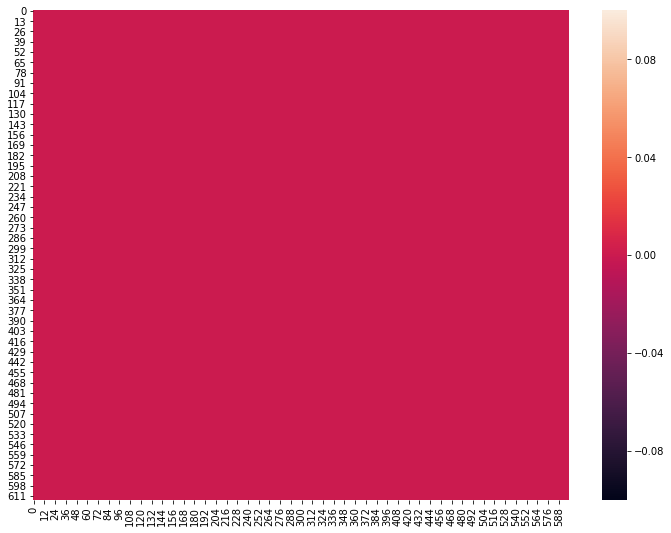

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,9))
sns.heatmap(x[14, ...])

# Temporary uploading of .tif files

In [11]:
from glob import glob
uploader = FileUploader(awskey = AWSKEY, awssecret = AWSSECRET)

path_to_folders = "../project-monitoring/tof/"

uploaded = 0
folders = glob(path_to_folders + "*/*/")
for folder in folders:
    files = [x for x in os.listdir(folder) if x[-4:] == '.tif']
    for file in files:
        internal_folder = folder[len(path_to_folders):]
        key = f'2020/tiles/{internal_folder}{file}'
        _file = folder + file
        print(uploaded)
        uploader.upload(bucket = 'tof-output', key = key, file = _file)

NameError: name 'FileUploader' is not defined

# Extra GDAL code

In [8]:
import os
from osgeo import gdal
from glob import glob
li_dirs = glob("../project-monitoring/mozambique/*")


print(li_dirs)
#li_all_files = list()
#for folder in li_dirs:
#    files = [file for file in os.listdir(folder) if os.path.splitext(file)[-1] == '.tif']
#    for file in files:
#        li_all_files.append(os.path.join(folder, file))
        

gdal.BuildVRT('mozambique.vrt', li_dirs)

!gdal_translate -of GTiff mozambique.vrt mozambique.tif -ot "Byte"

['../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S18E034_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S22E032_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S16E038_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S17E037_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S27E033_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S19E032_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S24E031_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S23E034_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S19E033_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S26E034_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S23E035_Map.tif', '../project-monitoring/mozambique/ESA_WorldCover_10m_2019_v100_S18E035_Map.tif', '../project-monitoring/moza

In [ ]:
!gdalwarp -s_srs "EPSG:4326" -t_srs "EPSG:32663" -of vrt in2.tif out.vrt
!gdal_translate -co compress=LZW out.vrt out.tif